# Discrete-time Controlled Invariant Set


An similar example is available in a [codeocean capsule](https://doi.org/10.24433/CO.6396918.v1).

## Introduction

This example considers the linear control system already introduced in the Example 2 of [LTJ20] (see also Example 2 of [LRJ20]):
$$\begin{align*}
x_{k+1} & = x_k + u_k / 2\\
u_{k+1} & = u_k'
\end{align*}$$
with $(x_k, u_k) \in [-1, 1]^2$.

The system is $x_{k+1} = Ax_k + Bu_k$ where $B = (0, 1)$ and
$$
A = \begin{bmatrix}
1 & 1/2\\
0 & 0
\end{bmatrix}.
$$
As shown in Example 4 of [LTJ18], a set $S \subseteq [-1, 1]^2$ is controlled invariant for this system if
$$
\begin{bmatrix}
1 & 1/2
\end{bmatrix}
S \subseteq
\begin{bmatrix}
1 & 0
\end{bmatrix}
S
$$

[LRJ20] Legat, Benoît, Saša V. Raković, and Raphaël M. Jungers.
*Piecewise semi-ellipsoidal control invariant sets.*
IEEE Control Systems Letters 5.3 (2020): 755-760.

[LTJ18] B. Legat, P. Tabuada and R. M. Jungers.
*Computing controlled invariant sets for hybrid systems with applications to model-predictive control*.
6th IFAC Conference on Analysis and Design of Hybrid Systems ADHS 2018, **2018**.

We need to pick an SDP solver, see [here](https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers) for a list of available ones. Run one of the following two cells to choose choose the solver.

In [1]:
using SetProg
import CSDP
solver = optimizer_with_attributes(CSDP.Optimizer, MOI.Silent() => true)
A = [1.0 0.5]
E = [1.0 0.0]
using Polyhedra
lib = DefaultLibrary{Float64}(solver)
h = HalfSpace([1, 0], 1.0) ∩ HalfSpace([-1, 0], 1) ∩ HalfSpace([0, 1], 1) ∩ HalfSpace([0, -1], 1)
□ = polyhedron(h, lib) # [0, 1]^2
v = convexhull([1.0, 0], [0, 1], [-1, 0], [0, -1])
◇ = polyhedron(v, lib); # polar of [0, 1]^2

## Polyhedral template

This section shows that the maximal control invariant set of this simple control system is polyhedral. Moreover, this polyhedron is obtained after only one fixed point iteration of the standard viability
kernel algorithm. We implement the fixed point iteration with the following function:

In [2]:
function fixed_point_iteration(set::Polyhedron)
    new_set = set ∩ (A \ (E * set))
    removehredundancy!(new_set)
    return new_set
end

fixed_point_iteration (generic function with 1 method)

We start with $[-1, 1]^2$ and obtain the polytope `mci` after one iteration.

In [3]:
mci = fixed_point_iteration(□)

Polyhedron DefaultPolyhedron{Float64, Polyhedra.Intersection{Float64, Vector{Float64}, Int64}, Polyhedra.Hull{Float64, Vector{Float64}, Int64}}:
6-element iterator of HalfSpace{Float64, Vector{Float64}}:
 HalfSpace([1.0, 0.0], 1.0)
 HalfSpace([-1.0, 0.0], 1.0)
 HalfSpace([0.0, 1.0], 1.0)
 HalfSpace([0.0, -1.0], 1.0)
 HalfSpace([1.0, 0.5], 1.0)
 HalfSpace([-0.5, -0.25], 0.5)

One additional iteration gives the same polytope, showing that this polytope is control invariant.

In [4]:
fixed_point_iteration(mci)

Polyhedron DefaultPolyhedron{Float64, Polyhedra.Intersection{Float64, Vector{Float64}, Int64}, Polyhedra.Hull{Float64, Vector{Float64}, Int64}}:
6-element iterator of HalfSpace{Float64, Vector{Float64}}:
 HalfSpace([1.0, 0.0], 1.0)
 HalfSpace([-1.0, 0.0], 1.0)
 HalfSpace([0.0, 1.0], 1.0)
 HalfSpace([0.0, -1.0], 1.0)
 HalfSpace([-1.0, -0.5], 1.0)
 HalfSpace([0.5, 0.25], 0.5)

We plot this polytope `mci` in yellow below along with the safe set $[-1, 1]^2$ in green.

In [5]:
using Plots
function hexcolor(rgb::UInt32)
    r = ((0xff0000 & rgb) >> 16) / 255
    g = ((0x00ff00 & rgb) >>  8) / 255
    b = ((0x0000ff & rgb)      ) / 255
    Plots.RGBA(r, g, b)
end

hexcolor (generic function with 1 method)

Values taken from http://www.toutes-les-couleurs.com/code-couleur-rvb.php

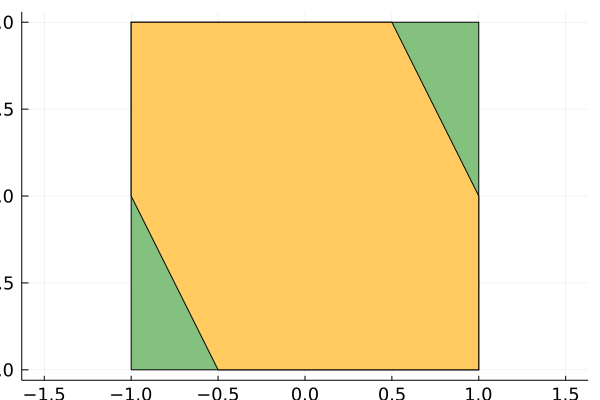

In [6]:
lichen = hexcolor(0x85c17e)
canard = hexcolor(0x048b9a)
aurore = hexcolor(0xffcb60)

plot(ratio=:equal, tickfont=Plots.font(12))
plot!(□, color=lichen)
plot!(mci, color=aurore)

We also plot their respective polars. Note that the inclusion is reversed in the polar space.

TODO use polar of Polyhedra

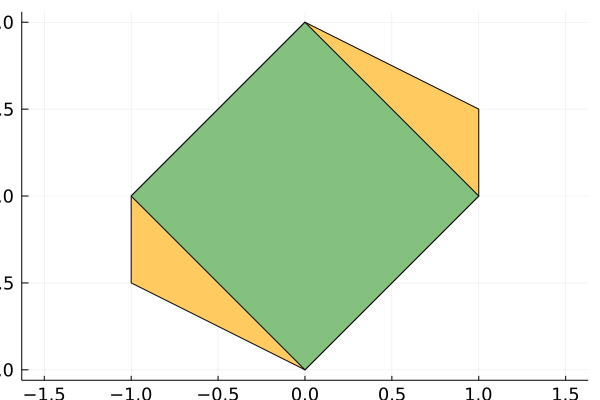

In [7]:
polar_mci = polyhedron(convexhull(
    [1.0, 0.0], [-1.0, 0.0],
        [0.0, 1.0], [0.0, -1.0],
        [1.0, 0.5], [-1.0, -0.5]
), lib)
plot(ratio=:equal, tickfont=Plots.font(12))
plot!(polar_mci, color=aurore)
plot!(◇, color=lichen)

## Ellipsoidal template

We now compute the maximal ellipsoidal control invariant set. Here we can either maximize its volume (which corresponds to $\log(\det(Q))$ or $\sqrt[n]{\det(Q)}$ in the objective function) or minimize the sum of the squares of the length of its semi-axes of the polar (which corresponds to the trace of $Q$ in the objective function).

In [8]:
function maximal_invariant(template, heuristic::Function)
    model = Model(solver)
    @variable(model, S, template)
    @constraint(model, S ⊆ □)
    @constraint(model, A * S ⊆ E * S)
    @objective(model, Max, heuristic(volume(S)))
    optimize!(model)
    @show solve_time(model)
    @show termination_status(model)
    @show objective_value(model)
    return value(S)
end
function primal_plot(set; npoints=256, args...)
    plot(ratio=:equal, tickfont=Plots.font(12); args...)
    plot!(□, color=lichen)
    plot!(mci, color=aurore)
    plot!(set, color=canard, npoints=npoints)
end
function polar_plot(set; npoints=256, args...)
    plot(ratio=:equal, tickfont=Plots.font(12); args...)
    plot!(SetProg.Sets.polar(set), color=canard, npoints=npoints)
    plot!(polar_mci, color=aurore)
    plot!(◇, color=lichen)
end
function _print_gauge_function(ell::SetProg.Sets.Ellipsoid, x)
    print(" ")
    println(x' * round.(ell.Q, digits=6) * x)
end
function print_support_function(set::SetProg.Sets.Polar)
    SetProg.@polyvar x[1:2]
    print("h(S, x) =")
    _print_gauge_function(SetProg.Sets.polar(set), x)
end

print_support_function (generic function with 1 method)

We can see below that the control invariant set of maximal volume has support function
$$h^2(S, x) = x_1^2 - \frac{1}{2} x_1x_2 + x_2^2.$$

In [9]:
sol_ell_vol = maximal_invariant(Ellipsoid(symmetric=true, dimension=2), nth_root)
print_support_function(sol_ell_vol)

solve_time(model) = 0.24768900871276855
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 0.9682458357349808
h(S, x) = x[1]^2 - 0.5*x[1]*x[2] + x[2]^2


We can see below the ellipsoid in blue along with the maximal control invariant set in yellow and the safe set in green.

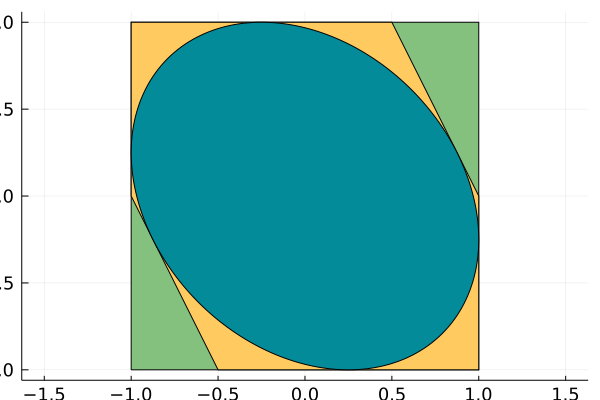

In [10]:
primal_plot(sol_ell_vol)

Below is are the corresponding sets in the polar space.

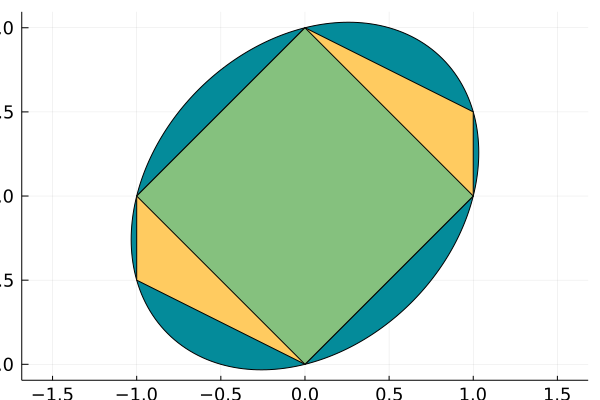

In [11]:
polar_plot(sol_ell_vol)

We can see below that the control invariant set of minimal sum of squares of the length of the semi-axes of the polar has support function
$$h^2(S, x) = x_1^2 - \alpha x_1x_2 + x_2^2.$$
with $\alpha \approx 1.377456$.
Note that the sum of the squares of the length of the semi-axes of the polar is equal to the integral of $h^2(S, x)$ over the hypercube $[-1, 1]^2$ hence the use of the `L1_heuristic(vol, ones(2))` as objective which means taking the integral over the hyperrectangle with vertex `ones(2) = [1, 1]`.

In [12]:
sol_ell_L1 = maximal_invariant(Ellipsoid(symmetric=true, dimension=2), vol -> L1_heuristic(vol, ones(2)))
print_support_function(sol_ell_L1)

solve_time(model) = 0.0032918453216552734
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 0.66666666551825
h(S, x) = x[1]^2 - 1.204768*x[1]*x[2] + x[2]^2


The primal plot is below:

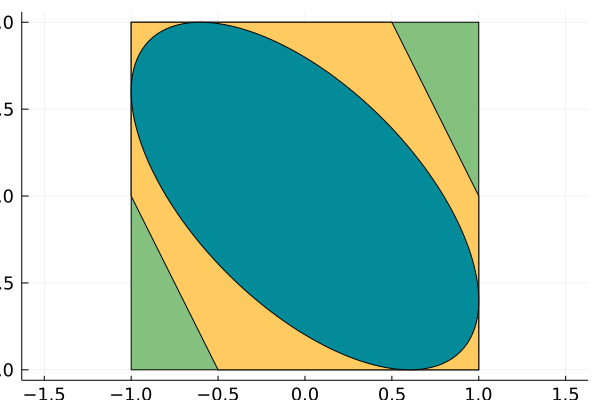

In [13]:
primal_plot(sol_ell_L1)

And the polar plot is below:

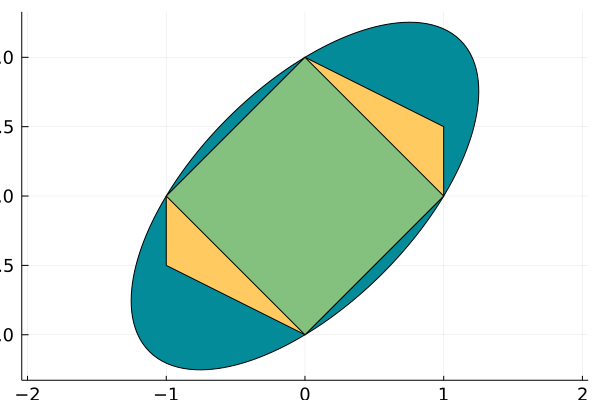

In [14]:
polar_plot(sol_ell_L1)

# Piecewise semi-ellipsoidal template

#We now study the maximal piecewise semi-ellipsoidal control invariant sets of a given conic partition.
#The volume is not directly maximized. Instead, for each cone, we compute the sum $s$ of the normalized rays and consider the polytope obtained by intersecting the cone with the halfspace $s^\top x \le \|s\|_2^2$. We integrate the quadratic form corresponding to this cone, i.e. $h^2(S, x)$ over the polytope. The sum of the integrals over each polytope is the objective function we use. This can be seen as the generalization of the sum of the squares of the semi-axes of the polar of the ellipsoid.

In [15]:
#Note that the constraint (29) of Program 1 of [LRJ20] is implemented with Proposition 2 of [LRJ20] for all results of this capsule.

function _print_gauge_function(set, x)
    println()
    for (set, piece) in zip(set.sets, set.pieces)
        print("         ")
        _print_gauge_function(set, x)
        print("              if ")
        for (i, h) in enumerate(halfspaces(piece))
            if i > 1
                print(", ")
            end
            a = -h.a
            if count(!iszero, a) == 1
                a /= abs(sum(a)) # Simplify printing
            end
            print(a'x)
            print(" ≥ 0")
        end
        println()
    end
end

_print_gauge_function (generic function with 2 methods)

The conic partition are obtained by considering the conic hull of each facets of a given polytope.
We first consider the conic partition corresponding to the polar of the safe set $[-1, 1]^2$. This gives the four quadrants as cones of the conic partition.
The maximal piecewise semi-ellipsoidal control invariant set with this partition has the following support function:
$$
h^2(S, x) = \begin{cases}
(x_1 - x_2)^2 & \text{ if }x_1x_2 \le 0,\\
x_1^2 - x_1x_2/2 + x_2^2 & \text{ if }x_1x_2 \ge 0.
\end{cases}
$$
For the cones $x_1x_2 \le 0$, the semi-ellipsoid matches the safe set and the maximal control invariant set.
For the cones $x_1x_2 \ge 0$, the semi-ellipsoid matches the maximal volume control invariant ellipsoid.
This illustrates one key feature of piecewise semi-ellipsoidal sets, they can combines advantages of both polyhedra and ellipsoids. It can be polyhedral on the directions where the maximal control invariant set is polyhedral and be ellipsoidal on the directions where the maximal control invariant set is smooth or requires many halfspaces in its representation.

In [16]:
sol_piece_◇ = maximal_invariant(Ellipsoid(symmetric=true, piecewise=◇), L1_heuristic)
print_support_function(sol_piece_◇)

solve_time(model) = 0.0949099063873291
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 3.166666662946419
h(S, x) =
          x[1]^2 - 0.5*x[1]*x[2] + x[2]^2
              if x[2] ≥ 0, x[1] ≥ 0
          x[1]^2 - 2.0*x[1]*x[2] + x[2]^2
              if -x[2] ≥ 0, x[1] ≥ 0
          x[1]^2 - 2.0*x[1]*x[2] + x[2]^2
              if -x[1] ≥ 0, x[2] ≥ 0
          x[1]^2 - 0.5*x[1]*x[2] + x[2]^2
              if -x[1] ≥ 0, -x[2] ≥ 0


The primal plot is below:

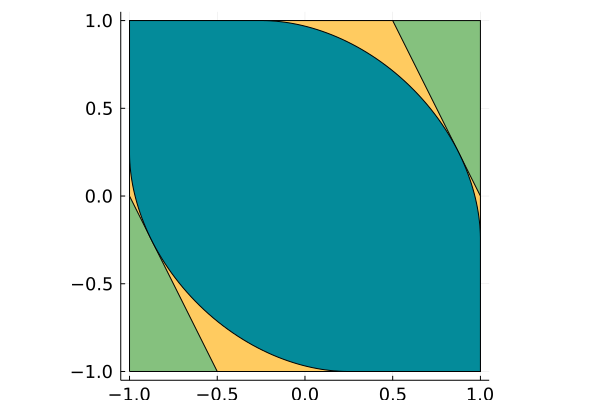

In [17]:
primal_plot(sol_piece_◇, xlim=(-1.05, 1.05), ylim=(-1.05, 1.05))

And the polar plot is below:

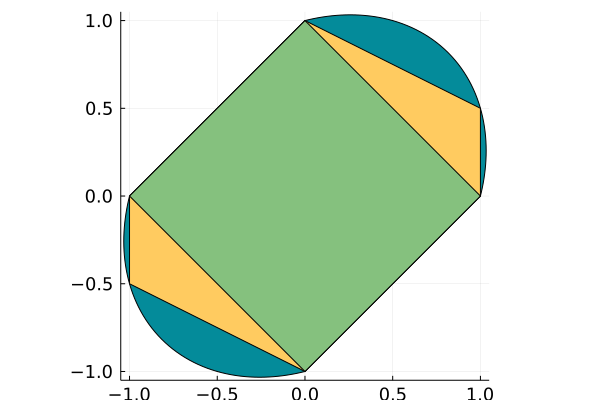

In [18]:
polar_plot(sol_piece_◇, xlim=(-1.05, 1.05), ylim=(-1.05, 1.05))

We can use the polar of the polytope resulting from the first fixed point iteration to generate a refined conic partition.
With this partition, the maximal piecewise semi-ellipsoidal control invariant set matches the maximal control invariant set. The support function is
$$
h^2(S, x) = \begin{cases}
(x_1 - x_2)^2 & \text{ if }x_1x_2 \le 0,\\
x_1^2 & \text{ if }x_2(x_1-2x_2) \ge 0,\\
(x_1/2 + x_2)^2 & \text{ if }x_1(2x_2-x_1) \ge 0.\\
\end{cases}
$$

In [19]:
sol_piece_mci = maximal_invariant(Ellipsoid(symmetric=true, piecewise=polar_mci), L1_heuristic)
print_support_function(sol_piece_mci)

solve_time(model) = 0.18735194206237793
termination_status(model) = MathOptInterface.OPTIMAL
objective_value(model) = 2.990943462033401
h(S, x) =
          x[1]^2
              if x[2] ≥ 0, 0.5*x[1] - x[2] ≥ 0
          x[1]^2 - 2.0*x[1]*x[2] + x[2]^2
              if -x[2] ≥ 0, x[1] ≥ 0
          0.25*x[1]^2 + x[1]*x[2] + x[2]^2
              if -0.5*x[1] + x[2] ≥ 0, x[1] ≥ 0
          x[1]^2 - 2.0*x[1]*x[2] + x[2]^2
              if -x[1] ≥ 0, x[2] ≥ 0
          x[1]^2
              if -x[2] ≥ 0, -0.5000000000000001*x[1] + x[2] ≥ 0
          0.25*x[1]^2 + x[1]*x[2] + x[2]^2
              if -x[1] ≥ 0, 0.5000000000000001*x[1] - x[2] ≥ 0


The primal plot is below:

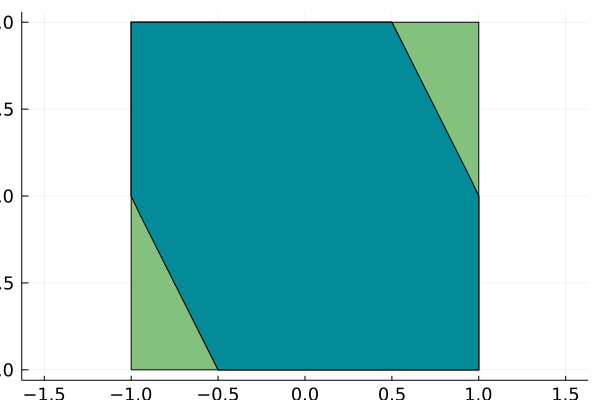

In [20]:
primal_plot(sol_piece_mci)

And the polar plot is below:

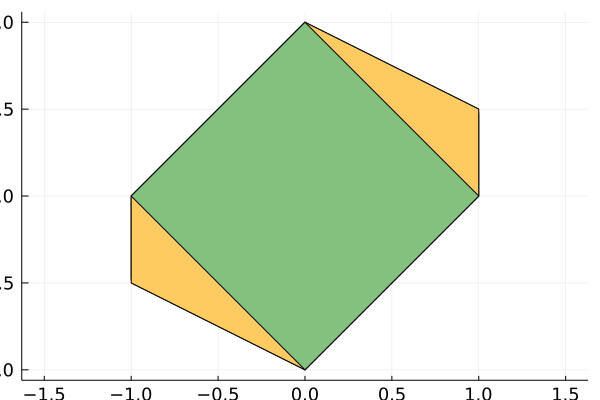

In [21]:
polar_plot(sol_piece_mci)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*